# Exploring time varying dynamics

## Importing the necessary modules

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np #numerical python used for working with arrays, mathematical operations
import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
usernm = "rmcgorty"
sys.path.append("C:/Users/%s/Documents/GitHub/PyDDM/PyDDM" % usernm) #must point to the PyDDM folder
### If you don't have PyDDM, get it here: https://github.com/rmcgorty/PyDDM
import ddm_analysis_and_fitting as ddm

import pickle #for saving data

## Example data -- 1 micron beads with stage moving at 7 microns/s

In [15]:
import yaml
ddm_analysis_parameters_str = """
DataDirectory: './'
FileName: '1um_Beads_7ums.tif'
Metadata:
  pixel_size: 0.186 # size of pixel in um
  frame_rate: 45.4 #frames per second
  channel: 0
Analysis_parameters:
  starting_frame_number: 0
  number_lag_times: 30
  last_lag_time: 600
  binning: no
  bin_size: 2
  use_windowing_function: no
Fitting_parameters:
  model: 'DDM Matrix - Single Exponential'
  Tau: [1.0, 0.001, 10]
  StretchingExp: [1.0, 0.5, 1.1]
  Amplitude: [1e2, 1, 1e6]
  Background: [2.5e4, 0, 1e7]
  Good_q_range: [5, 20]
  Auto_update_good_q_range: True
"""
parameters_as_dictionary = yaml.safe_load(ddm_analysis_parameters_str)
ddm_calc = ddm.DDM_Analysis(parameters_as_dictionary)

Provided metadata: {'pixel_size': 0.186, 'frame_rate': 45.4, 'channel': 0}
Image shape: 2000-by-128-by-128
Number of frames to use for analysis: 2000
Maximum lag time (in frames): 600
Number of lag times to compute DDM matrix: 30
Using the full frame, dimensions: 128-by-128.


In [36]:
dt = 1 #lag time (in frames)
sz = 4 #size of the region of the matrix of phases over which to fit a plane
phiDM = ddm_calc.phiDM(dt, sz, use_gf=True, gfsize=3, err_limit=2e-5)

phiDM.to_netcdf("phiDM_%s_dt%i_size%i.nc" % (ddm_calc.filename_for_saving_data, dt,sz)) #save to disk

With error threshold, magntiude of v = 5.927
Vx +/- stderr = -5.927 +/- 0.091
Vy +/- stderr = -0.032 +/- 0.089
Vx std deviation = 2.458
Vy std deviation = 2.397
Skew vx: 0.042
Skew vy: 0.028
median Vx +/- stderr = -5.951 +/- 0.091
median Vy +/- stderr = -0.092 +/- 0.089


Text(0, 0.5, 'Counts')

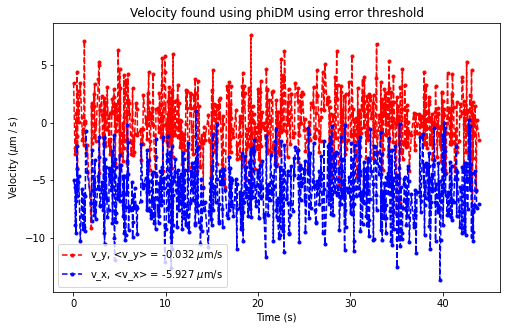

In [ ]:
fig,ax = plt.subplots(figsize=(8,8/1.618))

#Locate where the error is less than some limit
w = np.where(phiDM.error < phiDM.err_limit)

ax.plot(phiDM.vtime[w], phiDM.vy[w], '--r.', label='v_y, <v_y> = %.3f $\mu$m/s' % np.mean(phiDM.vy[w]))
ax.plot(phiDM.vtime[w], phiDM.vx[w], '--b.', label='v_x, <v_x> = %.3f $\mu$m/s' % np.mean(phiDM.vx[w]))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity ($\mu$m / s)")
plt.legend(loc=0)
ax.set_title("Velocity found using phiDM using error threshold")
print("With error threshold, magntiude of v = %.3f" % np.sqrt(np.mean(phiDM.vy[w])**2 + np.mean(phiDM.vx[w])**2))
print("Vx +/- stderr = %.3f +/- %.3f" % (np.mean(phiDM.vx[w]),np.std(phiDM.vx[w])/np.sqrt(len(w[0]))))
print("Vy +/- stderr = %.3f +/- %.3f" % (np.mean(phiDM.vy[w]),np.std(phiDM.vy[w])/np.sqrt(len(w[0]))))
print("Vx std deviation = %.3f" % np.std(phiDM.vx[w]))
print("Vy std deviation = %.3f" % np.std(phiDM.vy[w]))

skew_vx = np.mean(((phiDM.vx[w] - phiDM.vx[w].mean())**3)/ phiDM.vx[w].std()**3)
print("Skew vx: %.3f" % skew_vx)
skew_vy = np.mean(((phiDM.vy[w] - phiDM.vy[w].mean())**3)/ phiDM.vy[w].std()**3)
print("Skew vy: %.3f" % skew_vy)

print("median Vx +/- stderr = %.3f +/- %.3f" % (np.median(phiDM.vx[w]),np.std(phiDM.vx[w])/np.sqrt(len(w[0]))))
print("median Vy +/- stderr = %.3f +/- %.3f" % (np.median(phiDM.vy[w]),np.std(phiDM.vy[w])/np.sqrt(len(w[0]))))

fig,ax = plt.subplots(figsize=(8,8/1.618))
ax.set_title("Velocity found using phiDM without error threshold. Error shown as well.")
ax2 = ax.twinx()
w = np.where(phiDM.error < phiDM.err_limit)
ax.plot(phiDM.vtime, phiDM.vy, 'r.', label='v_y, <v_y> = %.3f $\mu$m/s' % np.mean(phiDM.vy))
ax.plot(phiDM.vtime, phiDM.vx, 'b.', label='v_x, <v_x> = %.3f $\mu$m/s' % np.mean(phiDM.vx))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity ($\mu$m / s)")
ax2.plot(phiDM.vtime, phiDM.error,'g.')
ax2.axhline(y=phiDM.err_limit)
ax2.set_ylabel("Error")
ax.legend(loc=0)

fig,ax = plt.subplots(figsize=(8,8/1.618))
w = np.where(phiDM.error < phiDM.err_limit)
ax.set_title("Histogram of velocities below error threshold.")
ax.hist(phiDM.vx[w], bins=30)
ax.set_xlabel("Velocity ($\mu$m/s)")
ax.set_ylabel("Counts")